In [1]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import lda
import numpy as np
import pandas as pd

Before deciding which model to build in the script requested by the exercise, I took the scraped wiki data and did some exploration to learn a bit about the data and test out a few different approaches.

##Training set construction

In [2]:
text_dict = pickle.load(open("text_dict.pkl", "r"))
target_dict = pickle.load(open("target_dict.pkl", "r"))
ind_cat_map = pickle.load(open("ind_cat_map.pkl", "r"))
cat_ind_map = pickle.load(open("cat_ind_map.pkl", "r"))

First I do some cleaning to transform the dictionaries into a feature vector and target vector. Initially, I will keep all of the labels for each example, to allow for multi-label training. 

In [3]:
def cat_list_to_vector(cat_list, n_topics):
    ret = np.zeros((1, n_topics))
    
    for c in cat_list:
        ret[0, c] = 1
    
    return ret

In [4]:
n_topics = len(cat_ind_map.keys())
documents = []
targets = np.zeros((len(text_dict.keys()), n_topics))

ct = 0
for k in sorted(text_dict.keys()):
    documents.append(text_dict[k])
    targets[ct, :] = cat_list_to_vector(target_dict[k], n_topics)
    ct += 1

We see below that 74 out of the 1063 articles have more than one category. Not a huge fraction, but I want to continue with the multi-label approach for now because it is more flexible. With this category set there is not a lot of overlap, but if you wanted to train on categories like "Presidents" and "Famous Men" there would be signiifcantly more overlap.

In [5]:
np.sum(np.sum(targets, axis=1) > 1)

74

In [6]:
targets.shape

(1063, 7)

As a first step, I try running a Random Forest on a simple bag of words model. Bag of words simply stores the count frequency of each word in the vocabulary for each document. In this case we get a 1063x4876 matrix (1063 documents, 4876 words in the vocabulary). Note that I put min_df = 10 as one of the parameters. This means that a word needs to be in at least ten documents to be included in the vocab. This reduces the size of the feature space from ~35k to ~5k, which will make fitting a bit less cumbersome. Including stop_words='english' will remove very common words like "and" and "the"

In [7]:
vectorizer = CountVectorizer(min_df = 10, stop_words='english')
bagofwords = vectorizer.fit_transform(documents)

In [8]:
vocab = vectorizer.get_feature_names()

In [9]:
len(vocab)

4876

I split into a training set and a test set so I can test the accuracy of the model on unseen examples.

In [10]:
from sklearn.cross_validation import train_test_split
train_text, test_text, train_targ, test_targ = train_test_split(bagofwords, targets, random_state=42)

In [11]:
print train_text.shape
print test_text.shape
print train_targ.shape
print test_targ.shape

(797, 4876)
(266, 4876)
(797, 7)
(266, 7)


## Model building

I start with a random forest because they are relatively easy to use and quick to train

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, max_features='sqrt')
rf.fit(train_text, train_targ)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [13]:
from sklearn.metrics import accuracy_score
preds = rf.predict(test_text)
print accuracy_score(test_targ, preds)

0.676691729323


The accuracy I got with the above model wasn't too great (68% as seen above). But, we need to keep in mind that accuracy_score in a multi-label context will only label the example as correct if ALL of the labels are correctly assigned. So the accuracy in each category is likely better than that (more on that below). 

Another improvement is to move to TF-IDF vectors instead of simple count vectors. In this case, the word counts are normalized by their document frequency. So, words that appear in every document are less significant than words that appear only a few times. I believe this will help the discrimination.

In [134]:
tfidf_tf = TfidfVectorizer(min_df = 10, stop_words='english')
tfidf_words = tfidf_tf.fit_transform(documents)
train_text_tfidf, test_text_tfidf, train_targ, test_targ = train_test_split(tfidf_words, targets, random_state=42)

In [135]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_text_tfidf, train_targ)
preds_tfidf = rf.predict(test_text_tfidf)
print accuracy_score(test_targ, preds_tfidf)

0.68045112782


We got a slight improvement in accuracy, but nothing major.

I now try for two other improvements. The first is switching from a Random Forest (RF) to a Gradient Boosting Tree (GB). I know from my experience on Kaggle that GB tends to perform better than RF for many problems. So I wanted to give it a try. The other thing I decided to do was to use sklearn's OneVsRestClassifier. With multi-label training, the OvR classifier in sklearn will train a separate classifier for each category. This might perform better than trying to predict all the labels together.

In [137]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
ovr = OneVsRestClassifier(GradientBoostingClassifier())
ovr.fit(train_text_tfidf.toarray(), train_targ)

OneVsRestClassifier(estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          n_jobs=1)

In [138]:
preds_ovr = ovr.predict(test_text_tfidf.toarray())
print accuracy_score(test_targ, preds_ovr)

0.676691729323


In [139]:
for i in xrange(test_targ.shape[1]):
    print accuracy_score(test_targ[:,i], preds_ovr[:,i])

0.860902255639
0.962406015038
0.977443609023
0.857142857143
0.996240601504
0.996240601504
0.966165413534


Interestingly, we see a couple of things. First, the overall classifier ends up having the same accuracy as the RF counterpart! Also, I checked the individual category accuracies which seemed to be much better. Below, you can also see something that arises in the OvR that wasn't a problem with the RF. Since OvR treats everything independently, there is no guarantee that the document will be put in any of the categories. If we wanted to enforce that, we can normalize each prediction by the sum of the probabilities and try again.

In [140]:
(np.sum(preds_ovr, axis=1) < 1).sum()

34

In [141]:
(np.sum(preds_ovr, axis=1) > 1).sum()

34

In [142]:
preds_ovr_prob = ovr.predict_proba(test_text_tfidf.toarray())

In [143]:
np.sum(preds_ovr_prob, axis=1)

array([ 0.40266642,  1.04014936,  1.05185133,  1.48276814,  1.05520467,
        1.04379879,  0.38623334,  0.10699007,  1.3088554 ,  1.04158647,
        1.1267326 ,  0.64955941,  1.58021584,  1.09823506,  1.08953887,
        0.86597824,  1.12269891,  1.03987396,  0.7279247 ,  1.30815656,
        1.01600033,  1.62186746,  1.2425214 ,  1.25761603,  1.16871771,
        1.62920754,  1.27018249,  0.37439528,  1.63475308,  0.72871103,
        0.75067048,  1.09476065,  0.60717975,  1.10708061,  0.33300805,
        0.15000129,  1.12732841,  1.57742756,  0.88759416,  1.03016708,
        1.10039858,  0.98217779,  0.95063373,  0.53815352,  0.99602177,
        1.23863697,  0.27826074,  1.11715993,  1.012323  ,  0.97008142,
        0.98672279,  1.02220978,  1.10523707,  1.12516829,  1.61233016,
        0.9914631 ,  1.67752623,  1.11082343,  0.94052657,  0.99161466,
        0.14902286,  1.13339026,  0.70402871,  1.01018112,  0.15693496,
        0.84526362,  1.1431236 ,  1.12329099,  1.53049497,  0.17

In [144]:
preds_ovr_prob_norm = preds_ovr_prob/np.sum(preds_ovr_prob, axis=1)[:, np.newaxis]

Now, we have an overall prediction accuracy of 79%, an improvement of ~11% compared to before! Additionally, the individual category accuracies look quite good.

In [145]:
print accuracy_score(test_targ, np.round(preds_ovr_prob_norm))

0.789473684211


In [146]:
for i in xrange(test_targ.shape[1]):
    print accuracy_score(test_targ[:,i], np.round(preds_ovr_prob_norm[:,i]))

0.853383458647
0.96992481203
0.981203007519
0.883458646617
0.996240601504
0.996240601504
0.977443609023


We can also ask how well we do if we just ask for one category to be labeled correctly. As you can see below, the accuracy of that is ~84%!

In [147]:
# At least one label correct
np.sum(np.logical_and(test_targ, np.round(preds_ovr_prob_norm)), axis=1).sum()*1.0/test_targ.shape[0]

0.83834586466165417

Finally, we can see how well we do if we try to just label a single category rather than doing the multi-label approach. To construct this training set, if there is more than one label for an example, I take the label that is most informative (i.e. the one that has the least entries in the category). 

In [148]:
targ_counts = np.sum(targets, axis=0)

In [149]:
targ_single = np.argmax(targets, axis=1)

In [150]:
overlap_inds = np.where(np.sum(targets, axis=1) > 1)[0]

In [151]:
for ind in overlap_inds:
    labels = targets[ind,:]
    pos_labs = np.where(labels > 0)[0]
    targ_single[ind] = pos_labs[np.argmin(targ_counts[pos_labs], axis=0)]

In [152]:
targ_single[overlap_inds]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3])

In [153]:
targ_single_tr, targ_single_te = train_test_split(targ_single, random_state=42)

In [154]:
gb_sing = GradientBoostingClassifier()
gb_sing.fit(train_text_tfidf.toarray(), targ_single_tr)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [155]:
preds_sing = gb_sing.predict(test_text_tfidf.toarray())
print accuracy_score(targ_single_te, preds_sing)

0.800751879699


The single class classifier gets an accuracy slightly above 80%. Not too bad! If we check below which categories are being confused with which others, we can see that category 0 (rare diseases) and 3 (congenital diseases) are the most mixed up. The row values are the true category and the column values are predicted. 19 examples have true category 3 but are predicted as 0, and 10 have true category 0 but are predicted as 3.

In [156]:
disagree = preds_sing != targ_single_te
pd.crosstab(targ_single_te[disagree], preds_sing[disagree])

col_0,0,1,2,3,5,6
row_0,,,,,,
0,0,2,2,10,1,4
1,6,0,0,0,0,0
2,3,0,0,0,0,0
3,19,0,0,0,0,1
4,1,0,0,0,0,0
6,4,0,0,0,0,0


In [157]:
targ_single_te[disagree]

array([4, 3, 0, 0, 0, 2, 0, 6, 0, 1, 3, 1, 6, 0, 0, 3, 3, 6, 3, 0, 0, 1, 0,
       3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 6, 0, 0, 0, 3, 1, 3, 0, 0, 3,
       0, 0, 1, 3, 2, 2, 3])

In [158]:
preds_sing[disagree]

array([0, 0, 1, 1, 3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 5, 3, 0, 3,
       0, 6, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 6, 0, 0, 0, 2, 2, 0,
       6, 6, 0, 0, 0, 0, 0])

I wanted to check how many of the predictions that are incorrect came from examples with multiple labels. Only 9 of them had multiple labels originally, which is ~3% of the test set. 

In [165]:
np.sum(np.sum(test_targ[disagree], axis=1) > 1)

9

## Visualizing the data

tSNE is a useful method for projecting high dimensional spaces down to 2 or 3 dimensions for visualization purposes. I wanted to see how the different categories looked in this projected space.

In [175]:
from sklearn.manifold import TSNE
tsne = TSNE(early_exaggeration=1)
tsne_coords = tsne.fit_transform(train_text_tfidf)

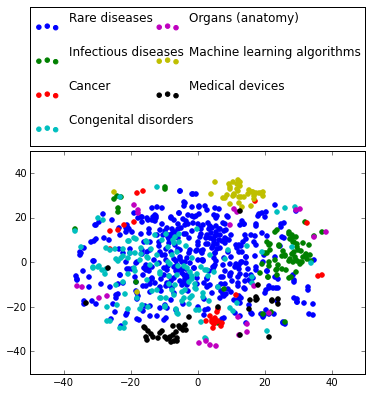

In [183]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
for targ in xrange(targets.shape[1]):
    examples = targ_single_tr == targ
    plt.scatter(tsne_coords[examples,0], tsne_coords[examples,1], color=colors[targ], label=ind_cat_map[targ])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

Interestingly, we see above what we also saw in our classification studies. Namely that rare diseases and congenital diseases have the most overlap. Machine learning, infectious diseases, and medical devices form nice clusters. Cancer is an interesting case because it has some articles clustered and others that are scattered around.

Finally, I wanted to use the single category model to evaluate which words were the most discriminative. Because GB is tree based, it has a nice feature importance metric.

In [205]:
tfidf_vocab = np.array(tfidf_tf.get_feature_names())
print tfidf_vocab[np.argsort(gb_sing.feature_importances_)[-25:]]
print gb_sing.feature_importances_[np.argsort(gb_sing.feature_importances_)[-25:]]

[u'usa' u'birth' u'lymph' u'instrument' u'models' u'induced' u'stain'
 u'target' u'named' u'spanish' u'condition' u'thymus' u'circular'
 u'congenital' u'rare' u'learning' u'mammals' u'technologies' u'products'
 u'organ' u'infectious' u'real' u'cancer' u'device' u'algorithm']
[ 0.00607508  0.00611015  0.00612096  0.00612924  0.00644763  0.00682076
  0.00809562  0.00867905  0.00900913  0.00912356  0.01010143  0.01137956
  0.01200072  0.01218482  0.01271205  0.01600413  0.01616756  0.01623708
  0.01756218  0.01981734  0.02001673  0.02267669  0.03518679  0.03764923
  0.06922034]


We see that the most informative word is "algorithm", which is very likely what allows the classifier to idenfity machine learning algorithms. "Cancer" and "device" are also very informative. 

##Final thoughts
In the end I've decided to go with the normalized OvR classifier. I like the fact that it is flexible enough to handle multi-label classification, and it has good accuracy both for getting at least one label correct and getting the combination of labels correct.

##Extensions/improvements

There are quite a few improvements I could have made if I had more time. These include:

- Tuning of the gradient boosting parameters
- Testing out other multi-label classification algorithms
- Better features (Google's word2vec and doc2vec stand out as good candidates)